# Betaflight System Identification

This notebook reads Betaflight blackbox logs (CSV format) and produces a JSON file of system identification parameters.

**Automatic Configuration Detection:**
The notebook automatically reads configuration parameters from the corresponding `.bbl` file:
- `minthrottle` - minimum throttle value
- `motorOutput` - motor output min/max range  
- `gyro_scale` - gyroscope scale factor
- `acc_1G` - accelerometer scale factor (units per 1G)

**Required CSV columns from blackbox log:**
- `time (us)` - timestamp in microseconds
- `gyroADC[0-2]` or `gyroUnfilt[0-2]` - gyro data (will be scaled using gyro_scale from .bbl)
- `accSmooth[0-2]` - accelerometer data (will be scaled using acc_1G from .bbl)
- `motor[0-3]` - motor outputs (will be normalized using motorOutput range from .bbl)
- `eRPM[0-3]` - (optional) actual motor RPM from ESC telemetry

**RPM-Based Estimation (if eRPM data available):**
1. Motor delay (T_m) is optimized using filtered motor commands
2. Filtered motor commands are compared to actual RPM to find scaling factor
3. Actual RPM (unfiltered) is used for final thrust and inertia estimation
4. This provides more accurate results than using filtered motor commands

**Output:**
- JSON file with thrust coefficients, inertia, motor time constants, etc.

In [113]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

## Configuration

Edit these parameters to match your quadcopter:

In [114]:
# Model configuration
model_name = "my_quad"  # Name for output files

# List your blackbox CSV files here
# These should be exported from Betaflight Blackbox Explorer
data_files = [
    '/home/miller/code/rl-betaflight/blackbox.01.csv',  # Edit these paths to match your log files
]

# Physical parameters - MUST be measured/known for your quad
mass = 0.036  # kg - total mass of quadcopter
arm_length = np.linalg.norm(np.array([0.028,0.028]))  # meters - distance from center to motor

# Inertia ratio (Izz / average of Ixx and Iyy) - typical range 1.5-2.5 for X-frame quads
inertia_ratio = 1.8

# Motor output normalization (fallback values if .bbl file not found)
# These will be automatically read from the .bbl file if available
motors_normalized = False
motor_pwm_min = 1000  # Fallback: only used if .bbl file is not found
motor_pwm_max = 2000  # Fallback: only used if .bbl file is not found

# Thrust curve polynomial exponents to try
exponents_thrust_curve = [[0, 1, 2]]

# Debug/output settings
dpi = 150
debug = False

In [115]:
# Build quadcopter model geometry
# Standard Betaflight motor layout (X configuration):
# Motor 1: Front Right (CW)
# Motor 2: Rear Right (CCW) 
# Motor 3: Rear Left (CW)
# Motor 4: Front Left (CCW)

rotor_x = arm_length * np.cos(np.pi/4)  # 45 degree arms
rotor_y = arm_length * np.sin(np.pi/4)

model = {
    "gravity": 9.81,
    "mass": mass,
    "rotor_positions": np.array([
        [-rotor_x, -rotor_y, 0],  # Motor 1: Rear Right
        [ rotor_x, -rotor_y, 0],  # Motor 2: Front Right
        [-rotor_x,  rotor_y, 0],  # Motor 3: Rear Left
        [ rotor_x,  rotor_y, 0]   # Motor 4: Front Left
    ]),
    "rotor_thrust_directions": np.array([
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]
    ]),
    "rotor_torque_directions": np.array([
        [0, 0,  1],  # Motor 1: CCW (positive torque)
        [0, 0, -1],  # Motor 2: CW (negative torque)
        [0, 0, -1],  # Motor 3: CW (negative torque)
        [0, 0,  1]   # Motor 4: CCW (positive torque)
    ])
}

g = np.array([0, 0, -model["gravity"]])

## Step 0: Load Betaflight Blackbox CSV Data

In [116]:
import struct
from pathlib import Path

def parse_bbl_config(bbl_filepath):
    """Parse configuration from a Betaflight blackbox .bbl file."""
    config = {}
    
    try:
        with open(bbl_filepath, 'rb') as f:
            # Read first 1000 lines which typically contain all headers
            for _ in range(1000):
                line = f.readline()
                if not line or not line.startswith(b'H '):
                    if line.startswith(b'H'):
                        continue
                    else:
                        break
                
                # Decode and parse header line
                try:
                    line_str = line.decode('utf-8', errors='ignore').strip()
                    if line_str.startswith('H '):
                        parts = line_str[2:].split(':', 1)
                        if len(parts) == 2:
                            key, value = parts
                            config[key.strip()] = value.strip()
                except:
                    continue
        
        # Extract relevant parameters
        result = {}
        
        # Parse minthrottle
        if 'minthrottle' in config:
            result['minthrottle'] = int(config['minthrottle'])
        
        # Parse motorOutput (min, max)
        if 'motorOutput' in config:
            motor_output = config['motorOutput'].split(',')
            if len(motor_output) >= 2:
                result['motor_output_min'] = int(motor_output[0])
                result['motor_output_max'] = int(motor_output[1])
        
        # # Parse gyro_scale (it's stored as a hex float)
        # if 'gyro_scale' in config:
        #     gyro_scale_hex = config['gyro_scale']
        #     if gyro_scale_hex.startswith('0x'):
        #         # Convert hex to float
        #         hex_int = int(gyro_scale_hex, 16)
        #         gyro_scale_float = struct.unpack('!f', struct.pack('!I', hex_int))[0]
        #         result['gyro_scale'] = gyro_scale_float
        
        # Parse acc_1G (accelerometer scale factor)
        if 'acc_1G' in config:
            result['acc_1G'] = int(config['acc_1G'])
        
        return result
    
    except Exception as e:
        print(f"Warning: Could not parse .bbl file: {e}")
        return {}

def load_betaflight_csv(csv_filepath, bbl_config=None):
    """Load a Betaflight blackbox CSV file and convert to standard format."""
    df = pd.read_csv(csv_filepath, sep=', ')
    
    flight = {
        "name": csv_filepath,
        "data": {}
    }
    
    # Get timestamps - convert from microseconds to seconds
    if 'time (us)' in df.columns:
        timestamps = np.array(df['time (us)']) * 1e-6
    elif 'time' in df.columns:
        timestamps = np.array(df['time'])
    else:
        raise ValueError(f"No time column found in {csv_filepath}")
    
    # Determine accelerometer scale from bbl_config or use default
    if bbl_config and 'acc_1G' in bbl_config:
        acc_1G = bbl_config['acc_1G']
        accel_scale = 9.81 / acc_1G
        print(f"  Using acc_1G = {acc_1G} from .bbl file (scale = {accel_scale:.6f})")
    else:
        accel_scale = 9.81 / 256  # Default Betaflight acc_1G
        print(f"  Using default acc_1G = 256 (scale = {accel_scale:.6f})")
    
    # Load accelerometer data
    accel_cols = ['accSmooth[0]', 'accSmooth[1]', 'accSmooth[2]']
    if all(col in df.columns for col in accel_cols):
        flight["data"]["vehicle_acceleration_xyz[0]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[0]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[1]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[1]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[2]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[2]']) * accel_scale
        }
    else:
        raise ValueError(f"Accelerometer columns not found in {csv_filepath}")
    
    # Determine gyro scale from bbl_config or use default
    if bbl_config and 'gyro_scale' in bbl_config:
        gyro_scale = bbl_config['gyro_scale'] * (np.pi / 180)  # gyro_scale is in deg/s per unit
        print(f"  Using gyro_scale = {bbl_config['gyro_scale']} from .bbl file")
    else:
        gyro_scale = np.pi / 180  # Default: assume deg/s
        print(f"  Using default gyro scale (assume deg/s)")
    
    # Load gyro data - prefer filtered (gyroADC) over unfiltered
    gyro_cols = ['gyroADC[0]', 'gyroADC[1]', 'gyroADC[2]']
    gyro_unfilt_cols = ['gyroUnfilt[0]', 'gyroUnfilt[1]', 'gyroUnfilt[2]']
    
    if all(col in df.columns for col in gyro_cols):
        gyro_source = gyro_cols
    elif all(col in df.columns for col in gyro_unfilt_cols):
        gyro_source = gyro_unfilt_cols
    else:
        raise ValueError(f"Gyro columns not found in {csv_filepath}")
    
    flight["data"]["vehicle_angular_velocity_xyz[0]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[0]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[1]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[1]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[2]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[2]]) * gyro_scale
    }
    
    # Determine motor output range from bbl_config or use defaults
    if bbl_config and 'motor_output_min' in bbl_config and 'motor_output_max' in bbl_config:
        motor_min = bbl_config['motor_output_min']
        motor_max = bbl_config['motor_output_max']
        print(f"  Using motor output range [{motor_min}, {motor_max}] from .bbl file")
    else:
        motor_min = motor_pwm_min
        motor_max = motor_pwm_max
        print(f"  Using default motor output range [{motor_min}, {motor_max}]")
    
    # Load motor outputs
    motor_cols = ['motor[0]', 'motor[1]', 'motor[2]', 'motor[3]']
    if all(col in df.columns for col in motor_cols):
        for i, col in enumerate(motor_cols):
            motor_values = np.array(df[col])
            # Normalize to 0-1
            if not motors_normalized:
                motor_values = (motor_values - motor_min) / (motor_max - motor_min)
                motor_values = np.clip(motor_values, 0, 1)
            flight["data"][f"motor_control[{i}]"] = {
                "timestamps": timestamps,
                "values": motor_values
            }
    else:
        raise ValueError(f"Motor columns not found in {csv_filepath}")
    
    # Load eRPM data if available
    erpm_cols = ['eRPM[0]', 'eRPM[1]', 'eRPM[2]', 'eRPM[3]']
    if all(col in df.columns for col in erpm_cols):
        print(f"  Found eRPM columns - loading actual RPM data")
        for i, col in enumerate(erpm_cols):
            erpm_values = np.array(df[col])
            flight["data"][f"actual_rpm[{i}]"] = {
                "timestamps": timestamps,
                "values": erpm_values
            }
    else:
        print(f"  Warning: eRPM columns not found in CSV")
    
    return flight

# Load all flight data
flights = []
for csv_file in data_files:
    try:
        print(f"\nLoading {csv_file}...")
        
        # Try to find corresponding .bbl file
        csv_path = Path(csv_file)
        # Remove the .XX suffix if present (e.g., .01.csv -> .csv)
        base_name = csv_path.stem
        if '.' in base_name:
            base_name = base_name.rsplit('.', 1)[0]
        bbl_path = csv_path.parent / f"{base_name}.bbl"
        
        bbl_config = None
        if bbl_path.exists():
            print(f"  Found .bbl file: {bbl_path}")
            bbl_config = parse_bbl_config(bbl_path)
            if bbl_config:
                print(f"  Parsed .bbl config: {bbl_config}")
        else:
            print(f"  No .bbl file found at {bbl_path}, using defaults")
        
        flight = load_betaflight_csv(csv_file, bbl_config)
        flights.append(flight)
        print(f"  Loaded {len(flight['data']['vehicle_acceleration_xyz[0]']['timestamps'])} samples")
    except Exception as e:
        print(f"  Error loading {csv_file}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print(f"Loaded {len(flights)} flight(s) total")
print(f"{'='*60}")


Loading /home/miller/code/rl-betaflight/blackbox.01.csv...
  Found .bbl file: /home/miller/code/rl-betaflight/blackbox.bbl
  Parsed .bbl config: {'minthrottle': 1070, 'motor_output_min': 1070, 'motor_output_max': 2000, 'acc_1G': 256}


/tmp/ipykernel_1441796/2621638330.py:65: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_filepath, sep=', ')


  Using acc_1G = 256 from .bbl file (scale = 0.038320)
  Using default gyro scale (assume deg/s)
  Using motor output range [1070, 2000] from .bbl file
  Found eRPM columns - loading actual RPM data
  Loaded 66497 samples

Loaded 1 flight(s) total


## Step 0.5: Compare Estimated vs Actual RPM (After Motor Delay)

If eRPM data is available, we'll apply the motor delay to the estimated RPM, then compare it to actual RPM and auto-compute the scaling factor. The actual RPM will be used for final thrust/inertia calculations.

In [117]:
# Check if actual RPM data is available
has_rpm_data = all('actual_rpm[0]' in flight["data"] for flight in flights)

if has_rpm_data:
    print("eRPM data found - will use for final estimation after motor delay optimization")
else:
    print("No eRPM data found - will use filtered motor commands")

eRPM data found - will use for final estimation after motor delay optimization


## Step 1: Plot the Flights

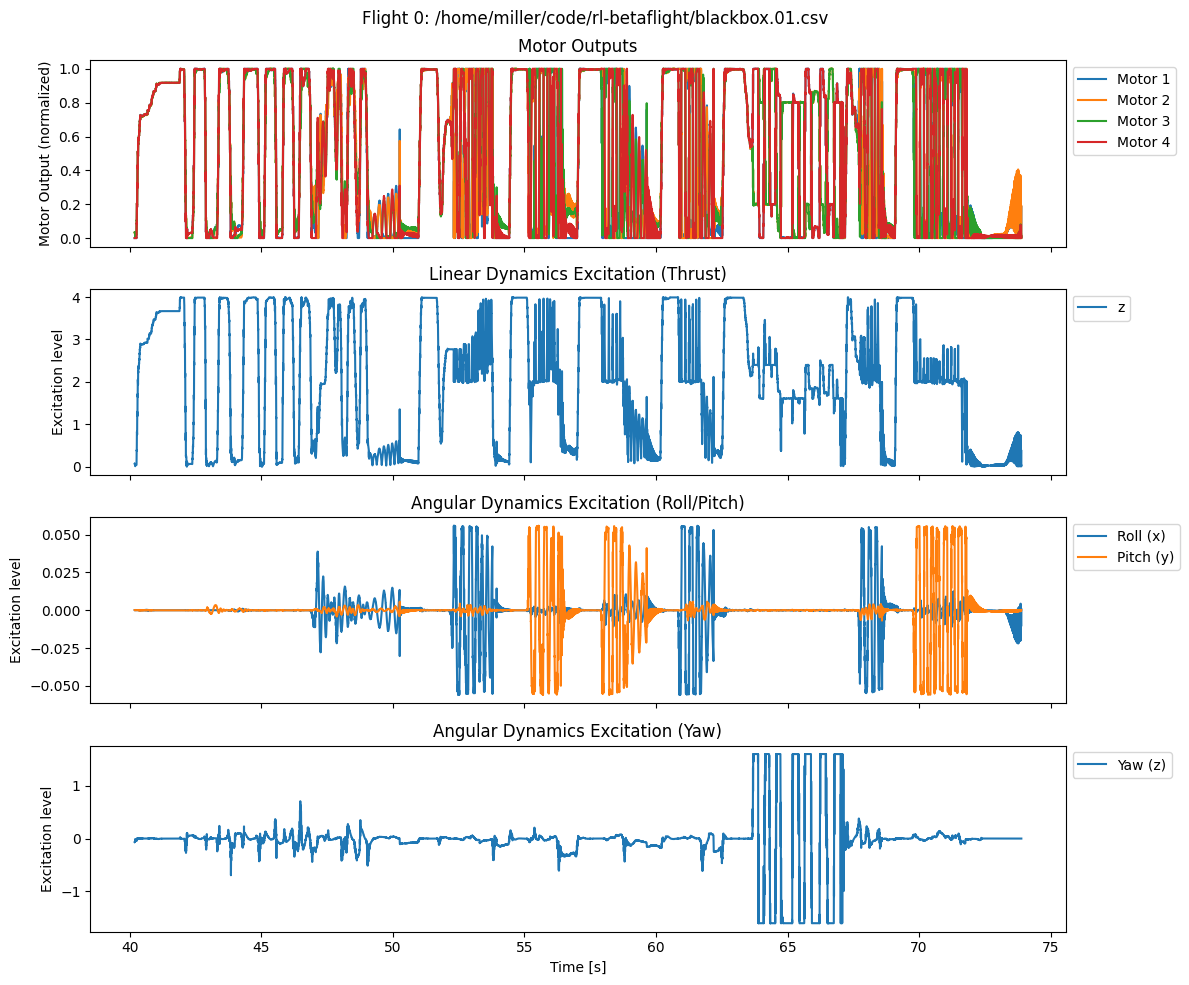

In [118]:
output_topic = "motor"

for flight_i, flight in enumerate(flights):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    ax = 0
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        axs[ax].plot(flight["data"][key]["timestamps"], flight["data"][key]["values"], label=f"Motor {motor_i+1}")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Motor Output (normalized)')
    axs[ax].set_title('Motor Outputs')
    ax += 1
    
    # Calculate thrust and torque excitation
    thrust_values = []
    thrust_torque_values = []
    geometric_torque_values = []
    timestamps = flight["data"]["motor_control[0]"]["timestamps"]
    
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        motor_vals = flight["data"][key]["values"]
        thrust_values.append(motor_vals[:, np.newaxis] * model["rotor_thrust_directions"][motor_i][np.newaxis, :])
        thrust_torque_values.append(motor_vals[:, np.newaxis] * model["rotor_torque_directions"][motor_i][np.newaxis, :])
        geometric_torque_values.append(motor_vals[:, np.newaxis] * np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i])[np.newaxis, :])
    
    thrust_values = sum(thrust_values)
    thrust_torque_values = sum(thrust_torque_values)
    geometric_torque_values = sum(geometric_torque_values)

    axs[ax].set_title("Linear Dynamics Excitation (Thrust)")
    axs[ax].plot(timestamps, thrust_values[:, 2], label="z")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Roll/Pitch)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 0], label="Roll (x)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 1], label="Pitch (y)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Yaw)")
    axs[ax].plot(timestamps, thrust_torque_values[:, 2], label="Yaw (z)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')

    axs[-1].set_xlabel('Time [s]')
    fig.suptitle(f"Flight {flight_i}: {flight['name']}")
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{model_name}_flight{flight_i}.png", dpi=dpi)
    plt.show()

## Step 2: Select Time Slices for System Identification

Select time ranges with good excitation for each identification task:
- **Thrust**: Vertical motion with varying throttle
- **Roll/Pitch Inertia**: Roll/pitch maneuvers 
- **Yaw Inertia**: Yaw maneuvers

In [119]:
# Edit these time ranges based on your flight data
# Look at the plots above to identify good excitation regions

timeframes_thrust = [
    {
        "flight": 0,
        "start": 5,  # seconds
        "end": 55
    }
]

timeframes_inertia_roll_pitch = [
    {
        "flight": 0,
        "start": 5,
        "end": 55
    }
]

timeframes_inertia_yaw = [
    {
        "flight": 0,
        "start": 5,
        "end": 55
    }
]

In [120]:
def extract_timeframes(flights, timeframes):
    """Extract time slices from flights."""
    output_flights = []
    fragment_counter = {}
    for timeframe in timeframes:
        flight = deepcopy(flights[timeframe["flight"]])
        fragment_id = fragment_counter.get(flight["name"], 0)
        fragment_counter[flight["name"]] = fragment_id + 1
        flight["name"] = flight["name"] + f".{fragment_id}"
        start, end = timeframe["start"], timeframe["end"]
        data = flight["data"]
        for series in data:
            mask = (data[series]["timestamps"] > start) & (data[series]["timestamps"] < end)
            data[series]["timestamps"] = data[series]["timestamps"][mask]
            data[series]["values"] = data[series]["values"][mask]
        output_flights.append(flight)
    return output_flights

flights_thrust = extract_timeframes(flights, timeframes_thrust)
flights_inertia_roll_pitch = extract_timeframes(flights, timeframes_inertia_roll_pitch)
flights_inertia_yaw = extract_timeframes(flights, timeframes_inertia_yaw)

print(f"Thrust timeframes: {len(flights_thrust)} segments")
print(f"Roll/Pitch inertia timeframes: {len(flights_inertia_roll_pitch)} segments")
print(f"Yaw inertia timeframes: {len(flights_inertia_yaw)} segments")

Thrust timeframes: 1 segments
Roll/Pitch inertia timeframes: 1 segments
Yaw inertia timeframes: 1 segments


## Step 3: Detect Gaps and Interpolate Data

In [121]:
def slice_gaps_and_interpolate(flights):
    """Handle gaps in data and interpolate to common timestamps."""
    flights_output = []
    for flight in flights:
        lowest_frequency = None
        lowest_frequency_name = None
        highest_frequency = None
        highest_frequency_name = None
        
        for name, data in flight["data"].items():
            diff = np.diff(data["timestamps"])
            if len(diff) == 0:
                continue
            frequency = 1/np.median(diff)
            if lowest_frequency is None or frequency < lowest_frequency:
                lowest_frequency = frequency
                lowest_frequency_name = name
            if highest_frequency is None or frequency > highest_frequency:
                highest_frequency = frequency
                highest_frequency_name = name

        if lowest_frequency is None:
            print(f"Skipping flight with no valid data")
            continue
            
        interval_threshold = 3 * 1/lowest_frequency
        print(f"Lowest frequency: {lowest_frequency:.1f} Hz for {lowest_frequency_name}")
        print(f"Highest frequency: {highest_frequency:.1f} Hz for {highest_frequency_name}")

        earliest_timestamp_all = max([data["timestamps"][0] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        latest_timestamp_all = min([data["timestamps"][-1] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        
        master_timestamps_full = flight["data"][highest_frequency_name]["timestamps"]
        master_timestamps = master_timestamps_full[(master_timestamps_full > earliest_timestamp_all) & (master_timestamps_full < latest_timestamp_all)]
        
        if len(master_timestamps) == 0:
            print(f"Skipping flight with no overlapping timestamps")
            continue
            
        earliest_timestamp = master_timestamps[0]
        latest_timestamp = master_timestamps[-1]
        total_time = latest_timestamp - earliest_timestamp

        # Find gaps
        gaps = []
        for name, data in flight["data"].items():
            current_timestamps_full = data["timestamps"]
            current_timestamps = current_timestamps_full[(current_timestamps_full > earliest_timestamp) & (current_timestamps_full < latest_timestamp)]
            current_timestamps_augmented = np.concatenate([[earliest_timestamp], current_timestamps, [latest_timestamp]])
            diff = np.diff(current_timestamps_augmented)
            current_gaps = np.where(diff > interval_threshold)[0]
            for gap in current_gaps:
                if gap < len(data["timestamps"]) - 1:
                    gap_start = data["timestamps"][gap]
                    gap_end = data["timestamps"][gap+1]
                    gaps.append((gap_start, gap_end))
        
        gaps_sorted = sorted(gaps, key=lambda x: x[0])

        # Combine overlapping gaps
        combined_gaps = []
        current_gap_start = None
        current_gap_end = None

        for i, (gap_start, gap_end) in enumerate(gaps_sorted):
            if current_gap_start is None:
                current_gap_start = gap_start
                current_gap_end = gap_end
            elif gap_start <= current_gap_end + interval_threshold:
                current_gap_end = max(current_gap_end, gap_end)
            else:
                combined_gaps.append((current_gap_start, current_gap_end))
                current_gap_start = gap_start
                current_gap_end = gap_end
        
        if current_gap_start is not None:
            combined_gaps.append((current_gap_start, current_gap_end))

        print(f"Number of gaps: {len(combined_gaps)}")
        
        total_gap_time = sum([gap_end - gap_start for gap_start, gap_end in combined_gaps])
        if total_gap_time >= 0.1 * total_time:
            print(f"Warning: Total gap time {total_gap_time:.2f}s is >= 10% of total time")

        # Create subflights from continuous segments
        subflights = []
        current_segment_start_timestamp = earliest_timestamp
        for gap_start, gap_end in [*combined_gaps, (latest_timestamp, latest_timestamp)]:
            segment_time = gap_start - current_segment_start_timestamp
            if segment_time > 0.01 * total_time:
                current_segment_timestamps = master_timestamps[(master_timestamps > current_segment_start_timestamp) & (master_timestamps < gap_start)]
                sub_flight = {
                    name: {
                        "timestamps": current_segment_timestamps,
                        "values": np.interp(current_segment_timestamps, data["timestamps"], data["values"])
                    } for name, data in flight["data"].items()
                }
                subflights.append(sub_flight)
            current_segment_start_timestamp = gap_end
        
        print(f"Number of subflights: {len(subflights)}")

        for subflight_i, subflight in enumerate(subflights):
            flights_output.append({
                "name": flight["name"] + f"_{subflight_i}",
                "timestamps": subflight[highest_frequency_name]["timestamps"],
                "data": subflight
            })
    return flights_output

In [122]:
print("Processing thrust data...")
sliced_and_interpolated_flights_thrust = slice_gaps_and_interpolate(flights_thrust)
print("\nProcessing roll/pitch inertia data...")
sliced_and_interpolated_flights_inertia_roll_pitch = slice_gaps_and_interpolate(flights_inertia_roll_pitch)
print("\nProcessing yaw inertia data...")
sliced_and_interpolated_flights_inertia_yaw = slice_gaps_and_interpolate(flights_inertia_yaw)

Processing thrust data...
Lowest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 76
Number of subflights: 36

Processing roll/pitch inertia data...
Lowest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 76
Number of subflights: 36

Processing yaw inertia data...
Lowest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1992.0 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 76
Number of subflights: 36


## Step 4: Apply Motor Delay Filter and Combine Data

In [123]:
def filter_ema(timestamps, values, T_m):
    """Apply exponential moving average filter to model motor delay."""
    filtered = []
    current = None
    previous_t = None
    for t, value in zip(timestamps, values):
        if current is None:
            current = value
        else:
            delta_t = t - previous_t
            alpha = np.exp(-delta_t / T_m)
            current = alpha * current + (1 - alpha) * value
        filtered.append(current)
        previous_t = t
    return np.array(filtered)

def combine(flights, T_m, thrust_curves=None, use_actual_rpm=False, rpm_scale=None):
    """Combine flight data with motor delay filtering.
    
    Args:
        flights: List of flight data dictionaries
        T_m: Motor time constant for EMA filter (used for motor commands, not for actual RPM)
        thrust_curves: Optional thrust curve coefficients
        use_actual_rpm: If True and RPM data available, use actual RPM instead of filtered motor commands
        rpm_scale: Scale factor to convert actual RPM to normalized units (0-1 range)
    """
    for flight in flights:
        timestamps = flight["timestamps"]
        
        # Get motor setpoints
        motor_setpoints = np.array([flight["data"][f"motor_control[{i}]"]["values"] for i in range(4)]).T

        # Check if we should use actual RPM data
        has_rpm = all(f"actual_rpm[{i}]" in flight["data"] for i in range(4))
        
        if use_actual_rpm and has_rpm and rpm_scale is not None:
            # Use actual RPM data, normalized to 0-1 range
            # NO filtering applied to actual RPM - it's already the real measurement
            motors = np.array([flight["data"][f"actual_rpm[{i}]"]["values"] / rpm_scale for i in range(4)]).T
        else:
            # Use filtered motor commands (original behavior)
            # This applies the EMA filter with time constant T_m
            motors = filter_ema(timestamps, motor_setpoints, T_m)
        
        # Get acceleration and convert frame if needed
        acceleration_original = np.array([flight["data"][f"vehicle_acceleration_xyz[{i}]"]["values"] for i in range(3)]).T
        acceleration = acceleration_original
        
        # Get angular velocity and convert frame if needed
        omega = np.array([flight["data"][f"vehicle_angular_velocity_xyz[{i}]"]["values"] for i in range(3)]).T
        
        # Compute angular acceleration from gyro data
        domega = np.gradient(omega, timestamps, axis=0)
        
        flight["motor_setpoints"] = motor_setpoints
        flight["motors"] = motors
        flight["acceleration"] = acceleration
        flight["omega"] = omega
        flight["domega"] = domega
        
        if thrust_curves is not None:
            def apply_thrust_curves(motors, thrust_curves):
                thrusts = []
                for thrust_curve, motor in zip(thrust_curves, motors):
                    thrust = sum(coeff * motor**exp for exp, coeff in enumerate(thrust_curve))
                    thrusts.append(thrust)
                return np.array(thrusts)
            
            flight["thrusts"] = np.array([apply_thrust_curves(motors, thrust_curves) for motors in flight["motors"]])
            motor_thrust_to_torque_geometric = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) for motor_i in range(4)])
            flight["pre_torque"] = flight["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
            flight["pre_torque_geometric"] = flight["thrusts"][:, :, np.newaxis] * motor_thrust_to_torque_geometric
    
    thrusts_combined = {}
    if thrust_curves is not None:
        thrusts_combined = {
            "thrusts": np.concatenate([flight["thrusts"] for flight in flights]),
            "pre_torque": np.concatenate([flight["pre_torque"] for flight in flights]),
            "pre_torque_geometric": np.concatenate([flight["pre_torque_geometric"] for flight in flights]),
        }

    return {
        "motor_setpoints": np.concatenate([flight["motor_setpoints"] for flight in flights]),
        "motors": np.concatenate([flight["motors"] for flight in flights]),
        "acceleration": np.concatenate([flight["acceleration"] for flight in flights]),
        "omega": np.concatenate([flight["omega"] for flight in flights]),
        "domega": np.concatenate([flight["domega"] for flight in flights]),
        **thrusts_combined
    }, flights

In [124]:
# Test with initial motor time constant
T_m_test = 0.05
combined_test, _ = combine(sliced_and_interpolated_flights_thrust, T_m_test)
print(f"Combined data shape: {combined_test['acceleration'].shape}")

Combined data shape: (25258, 3)


## Step 5: Estimate Motor Parameters

In [125]:
def estimate_motor_parameters(combined, model, exponents, verbose=True, separate=True):
    """Estimate thrust curve coefficients using least squares."""
    b = []
    A = []
    num_steps = len(combined["motors"])
    
    for step_i in range(num_steps):
        acceleration = combined["acceleration"][step_i]
        b.append(model["mass"] * acceleration)
        current_A = []
        motor = combined["motors"][step_i]
        
        if separate:
            for motor_i in range(4):
                for exponent in exponents:
                    current_A.append(model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent)
        else:
            for exponent in exponents:
                acc = np.zeros(3)
                for motor_i in range(4):
                    acc += model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent
                current_A.append(acc)
        A.append(np.array(current_A).T)

    A = np.array(A).reshape(-1, (4 if separate else 1) * len(exponents))
    b = np.array(b).reshape(-1)
    
    if verbose:
        print(f"A shape: {A.shape}")
        print(f"b shape: {b.shape}")
    
    K_f = np.linalg.lstsq(A, b, rcond=None)[0].reshape(-1, len(exponents))
    rmse = np.sqrt(np.mean((A @ K_f.reshape(-1) - b) ** 2))
    
    if separate:
        K_f_full = np.array([[K_f[motor_i][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    else:
        K_f_full = np.array([[K_f[0][exponents.index(i)] if i in exponents else 0 for i in range(3)] for _ in range(4)])
    
    return K_f_full, rmse

In [126]:
# Find optimal motor time constant
from tqdm import tqdm

T_m_candidates = np.linspace(0.001, 0.3, 50 if not debug else 10)

results = []
for exponents in exponents_thrust_curve:
    exp_results = []
    for T_m in tqdm(T_m_candidates, desc=f"Exponents {exponents}"):
        combined, _ = combine(sliced_and_interpolated_flights_thrust, T_m)
        K_f, rmse = estimate_motor_parameters(combined, model, exponents, verbose=False, separate=False)
        exp_results.append((T_m, K_f, rmse))
    results.append(exp_results)

T_ms, K_fs, rmses = zip(*results[0])

Exponents [0, 1, 2]: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


Optimal motor time constant T_m: 0.1413 s
Thrust coefficients (from filtered motor commands): [0.02618871 0.082313   0.01679984]


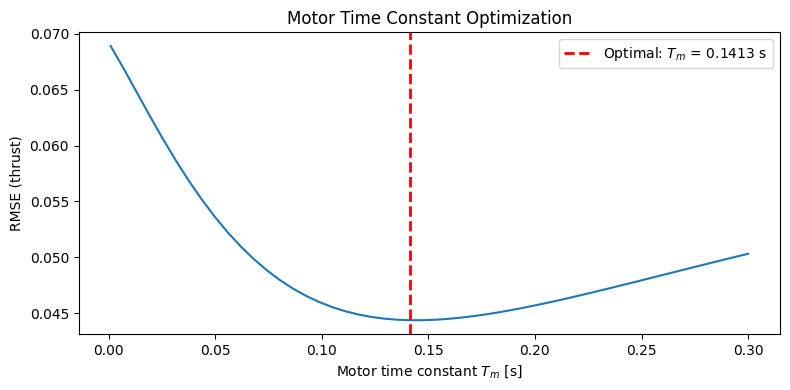

In [127]:
# Select best motor time constant
T_m = T_m_candidates[np.argmin(rmses)]
K_f = K_fs[np.argmin(rmses)]
K_f_mean = K_f.mean(axis=0)

print(f"Optimal motor time constant T_m: {T_m:.4f} s")
print(f"Thrust coefficients (from filtered motor commands): {K_f_mean}")

plt.figure(figsize=(8, 4))
plt.plot(T_m_candidates, rmses)
plt.xlabel("Motor time constant $T_m$ [s]")
plt.ylabel("RMSE (thrust)")
plt.axvline(x=T_m, color='red', linestyle='--', linewidth=2, label=f"Optimal: $T_m$ = {T_m:.4f} s")
plt.legend()
plt.title("Motor Time Constant Optimization")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_motor_time_constant.png", dpi=dpi)
plt.show()

In [128]:
# Re-estimate thrust coefficients using actual RPM data (if available)
if has_rpm_data:
    print("="*60)
    print("Re-estimating thrust coefficients using ACTUAL RPM data")
    print("="*60)
    
    # First, combine with actual RPM to get motor values from real RPM
    combined_rpm, _ = combine(
        sliced_and_interpolated_flights_thrust, T_m,
        use_actual_rpm=True, rpm_scale=rpm_scale_factor
    )
    
    # Re-estimate thrust coefficients with actual RPM
    K_f_rpm, rmse_rpm = estimate_motor_parameters(
        combined_rpm, model, exponents_thrust_curve[0], 
        verbose=True, separate=False
    )
    K_f_mean_rpm = K_f_rpm.mean(axis=0)
    
    print(f"\nThrust coefficients (from filtered motor commands): {K_f_mean}")
    print(f"Thrust coefficients (from actual RPM):              {K_f_mean_rpm}")
    print(f"\nRMSE (filtered motor commands): {rmses[np.argmin(rmses)]:.6f}")
    print(f"RMSE (actual RPM):              {rmse_rpm:.6f}")
    
    # Use the RPM-based coefficients for final estimation
    K_f_mean = K_f_mean_rpm
    print(f"\nUsing actual RPM coefficients for final estimation: {K_f_mean}")
else:
    print("="*60)
    print("No RPM data available - using filtered motor command coefficients")
    print("="*60)

# Now recombine with final thrust curves
thrust_curves = np.array([K_f_mean for _ in range(4)])

if has_rpm_data:
    combined_thrust, flights_thrust_processed = combine(
        sliced_and_interpolated_flights_thrust, T_m, thrust_curves=thrust_curves,
        use_actual_rpm=True, rpm_scale=rpm_scale_factor
    )
    combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(
        sliced_and_interpolated_flights_inertia_roll_pitch, T_m, thrust_curves=thrust_curves,
        use_actual_rpm=True, rpm_scale=rpm_scale_factor
    )
    combined_inertia_yaw, flights_inertia_yaw_processed = combine(
        sliced_and_interpolated_flights_inertia_yaw, T_m, thrust_curves=thrust_curves,
        use_actual_rpm=True, rpm_scale=rpm_scale_factor
    )
else:
    combined_thrust, flights_thrust_processed = combine(
        sliced_and_interpolated_flights_thrust, T_m, thrust_curves=thrust_curves
    )
    combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(
        sliced_and_interpolated_flights_inertia_roll_pitch, T_m, thrust_curves=thrust_curves
    )
    combined_inertia_yaw, flights_inertia_yaw_processed = combine(
        sliced_and_interpolated_flights_inertia_yaw, T_m, thrust_curves=thrust_curves
    )

Re-estimating thrust coefficients using ACTUAL RPM data
A shape: (75774, 3)
b shape: (75774,)

Thrust coefficients (from filtered motor commands): [0.02618871 0.082313   0.01679984]
Thrust coefficients (from actual RPM):              [0.00201231 0.03719046 0.0870853 ]

RMSE (filtered motor commands): 0.044361
RMSE (actual RPM):              0.020436

Using actual RPM coefficients for final estimation: [0.00201231 0.03719046 0.0870853 ]


## Step 5.5: Compare Filtered Motor Commands to Actual RPM (with optimal T_m)

Now that we have the optimal motor time constant, compare the delayed/filtered motor commands to actual RPM.

Comparing filtered motor commands (with T_m=0.1413s) to actual RPM
Computed RPM scaling factor: 21702.00
This means: actual_rpm ≈ 21702.00 * filtered_motor_cmd


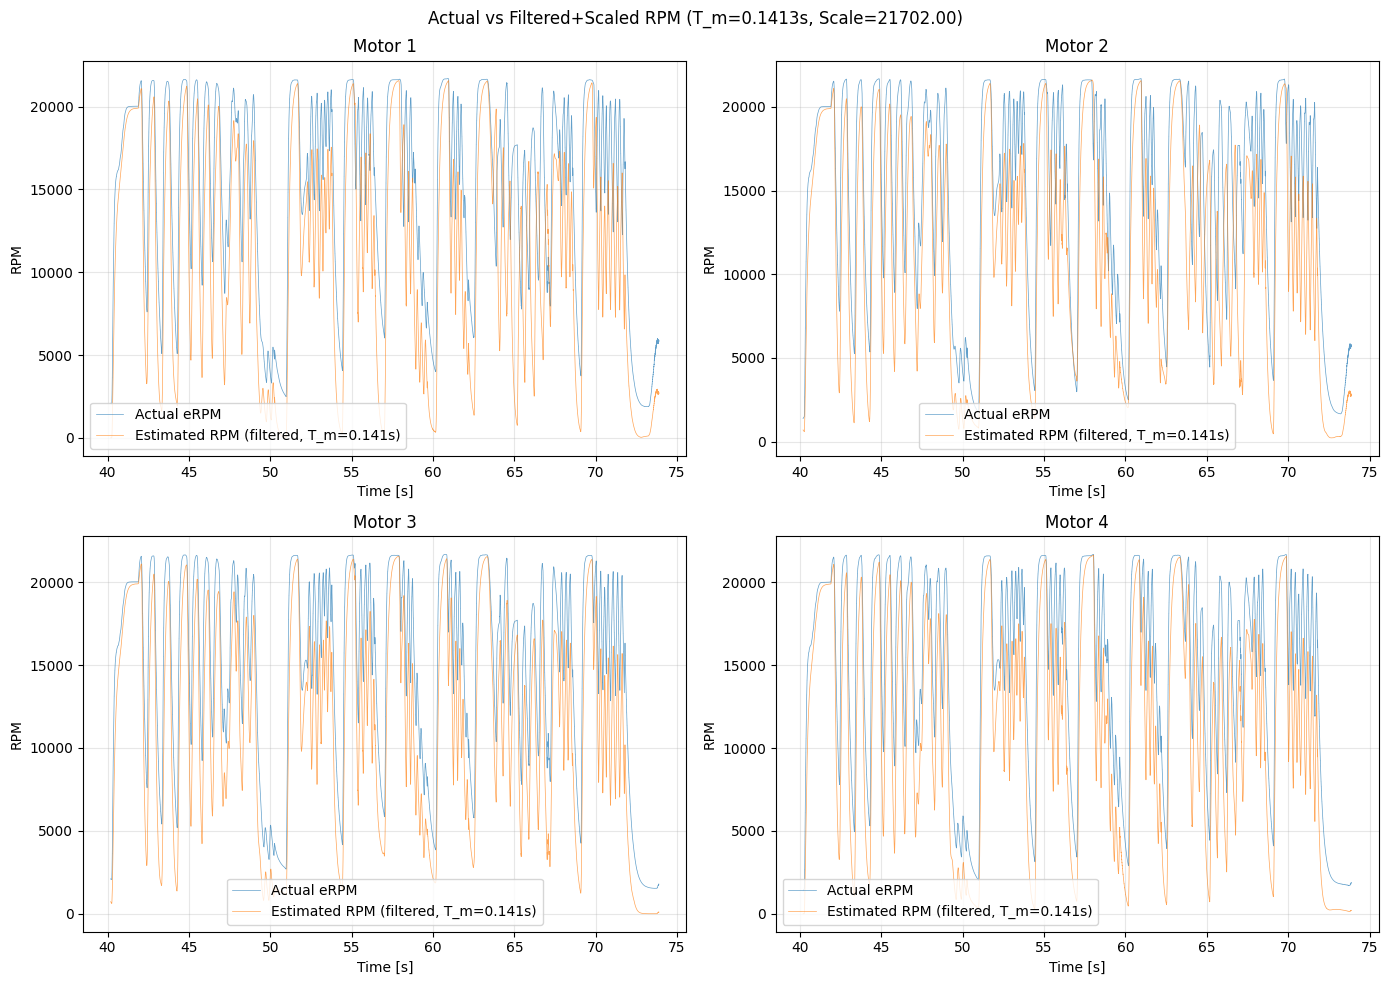

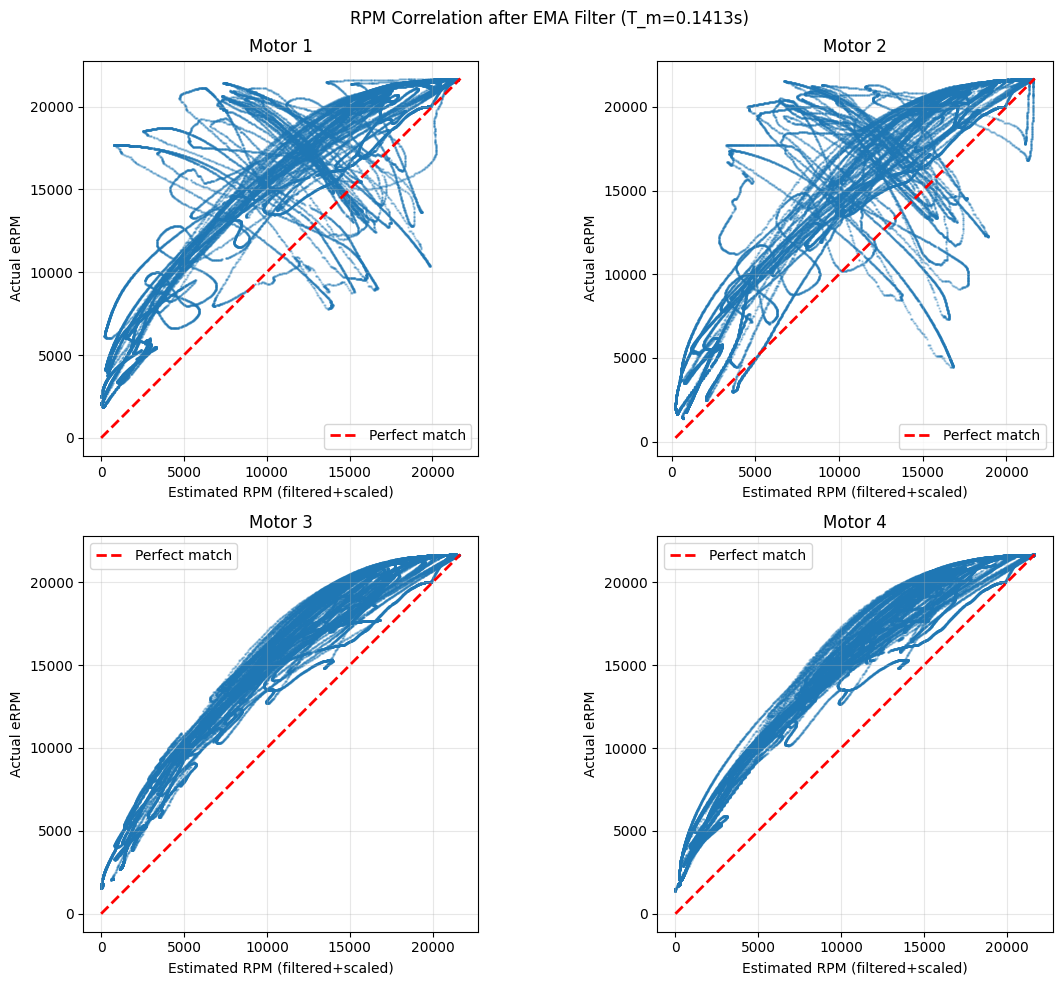


RPM Prediction RMSE by motor (after filtering):
  Motor 1: 5227.5 RPM (35.1% relative)
  Motor 2: 4918.1 RPM (33.3% relative)
  Motor 3: 3952.1 RPM (26.6% relative)
  Motor 4: 4111.3 RPM (27.9% relative)


In [129]:
if has_rpm_data:
    print("Comparing filtered motor commands (with T_m={:.4f}s) to actual RPM".format(T_m))
    
    # Apply motor delay filter to motor commands for all flights
    all_filtered_motors = []
    all_actual_rpms = []
    
    for flight in flights:
        timestamps = flight["data"]["motor_control[0]"]["timestamps"]
        
        for motor_i in range(4):
            motor_cmd = flight["data"][f"motor_control[{motor_i}]"]["values"]
            actual_rpm = flight["data"][f"actual_rpm[{motor_i}]"]["values"]
            
            # Apply the same EMA filter that will be used in estimation
            filtered_motor = filter_ema(timestamps, motor_cmd[:, np.newaxis], T_m).flatten()
            
            # Filter out zero/very low commands and RPMs for better scaling
            valid_mask = (filtered_motor > 0.1) & (actual_rpm > 100)
            all_filtered_motors.extend(filtered_motor[valid_mask])
            all_actual_rpms.extend(actual_rpm[valid_mask])
    
    all_filtered_motors = np.array(all_filtered_motors)
    all_actual_rpms = np.array(all_actual_rpms)
    
    # Compute optimal scaling factor using least squares
    # filtered_motor_cmd corresponds to actual_rpm
    # We want: actual_rpm ≈ rpm_scale_factor * filtered_motor_cmd
    rpm_scale_factor = 21702#np.sum(all_filtered_motors * all_actual_rpms) / np.sum(all_filtered_motors ** 2)
    
    print(f"Computed RPM scaling factor: {rpm_scale_factor:.2f}")
    print(f"This means: actual_rpm ≈ {rpm_scale_factor:.2f} * filtered_motor_cmd")
    
    # Plot comparison for first flight
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    flight = flights[0]
    
    for motor_i in range(4):
        ax = axs[motor_i // 2, motor_i % 2]
        
        motor_cmd = flight["data"][f"motor_control[{motor_i}]"]["values"]
        actual_rpm = flight["data"][f"actual_rpm[{motor_i}]"]["values"]
        timestamps = flight["data"][f"motor_control[{motor_i}]"]["timestamps"]
        
        # Apply EMA filter
        filtered_motor = filter_ema(timestamps, motor_cmd[:, np.newaxis], T_m).flatten()
        estimated_rpm = filtered_motor * rpm_scale_factor
        
        # Time series plot
        ax.plot(timestamps, actual_rpm, label='Actual eRPM', alpha=0.7, linewidth=0.5)
        ax.plot(timestamps, estimated_rpm, label=f'Estimated RPM (filtered, T_m={T_m:.3f}s)', alpha=0.7, linewidth=0.5)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('RPM')
        ax.set_title(f'Motor {motor_i + 1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Actual vs Filtered+Scaled RPM (T_m={T_m:.4f}s, Scale={rpm_scale_factor:.2f})')
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_comparison_timeseries.png", dpi=dpi)
    plt.show()
    
    # Scatter plot to show correlation
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    for motor_i in range(4):
        ax = axs[motor_i // 2, motor_i % 2]
        
        motor_cmd = flight["data"][f"motor_control[{motor_i}]"]["values"]
        actual_rpm = flight["data"][f"actual_rpm[{motor_i}]"]["values"]
        timestamps = flight["data"][f"motor_control[{motor_i}]"]["timestamps"]
        
        filtered_motor = filter_ema(timestamps, motor_cmd[:, np.newaxis], T_m).flatten()
        estimated_rpm = filtered_motor * rpm_scale_factor
        
        ax.scatter(estimated_rpm, actual_rpm, s=0.5, alpha=0.3)
        
        # Plot identity line
        max_val = max(actual_rpm.max(), estimated_rpm.max())
        min_val = min(actual_rpm.min(), estimated_rpm.min())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect match')
        
        ax.set_xlabel('Estimated RPM (filtered+scaled)')
        ax.set_ylabel('Actual eRPM')
        ax.set_title(f'Motor {motor_i + 1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    fig.suptitle(f'RPM Correlation after EMA Filter (T_m={T_m:.4f}s)')
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_correlation.png", dpi=dpi)
    plt.show()
    
    # Compute and display RMSE for each motor
    print("\nRPM Prediction RMSE by motor (after filtering):")
    for motor_i in range(4):
        motor_cmd = flight["data"][f"motor_control[{motor_i}]"]["values"]
        actual_rpm = flight["data"][f"actual_rpm[{motor_i}]"]["values"]
        timestamps = flight["data"][f"motor_control[{motor_i}]"]["timestamps"]
        
        filtered_motor = filter_ema(timestamps, motor_cmd[:, np.newaxis], T_m).flatten()
        estimated_rpm = filtered_motor * rpm_scale_factor
        
        rmse = np.sqrt(np.mean((actual_rpm - estimated_rpm) ** 2))
        relative_rmse = rmse / np.mean(actual_rpm) * 100
        print(f"  Motor {motor_i + 1}: {rmse:.1f} RPM ({relative_rmse:.1f}% relative)")
    
else:
    rpm_scale_factor = None

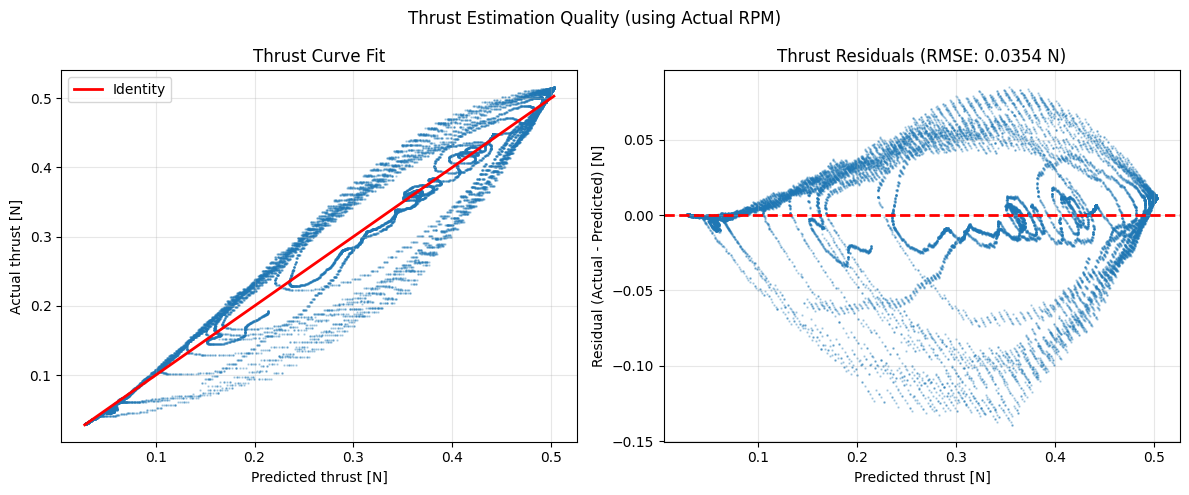

Thrust estimation RMSE: 0.0354 N
Mean absolute error: 0.0235 N
Data source: Actual RPM


In [130]:
# Plot thrust fit quality
predicted_thrust = combined_thrust["thrusts"].sum(axis=1)
actual_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax = axs[0]
ax.scatter(predicted_thrust, actual_thrust, s=0.5, alpha=0.3)
ax.plot([predicted_thrust.min(), predicted_thrust.max()], 
         [predicted_thrust.min(), predicted_thrust.max()], 
         linewidth=2, color="red", label="Identity")
ax.set_xlabel("Predicted thrust [N]")
ax.set_ylabel("Actual thrust [N]")
ax.legend()
ax.set_title("Thrust Curve Fit")
ax.grid(True, alpha=0.3)

# Residuals plot
ax = axs[1]
residuals = actual_thrust - predicted_thrust
ax.scatter(predicted_thrust, residuals, s=0.5, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel("Predicted thrust [N]")
ax.set_ylabel("Residual (Actual - Predicted) [N]")
rmse = np.sqrt(np.mean(residuals**2))
ax.set_title(f"Thrust Residuals (RMSE: {rmse:.4f} N)")
ax.grid(True, alpha=0.3)

data_source = "Actual RPM" if has_rpm_data else "Filtered Motor Commands"
fig.suptitle(f"Thrust Estimation Quality (using {data_source})")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_thrust_fit.png", dpi=dpi)
plt.show()

print(f"Thrust estimation RMSE: {rmse:.4f} N")
print(f"Mean absolute error: {np.mean(np.abs(residuals)):.4f} N")
print(f"Data source: {data_source}")

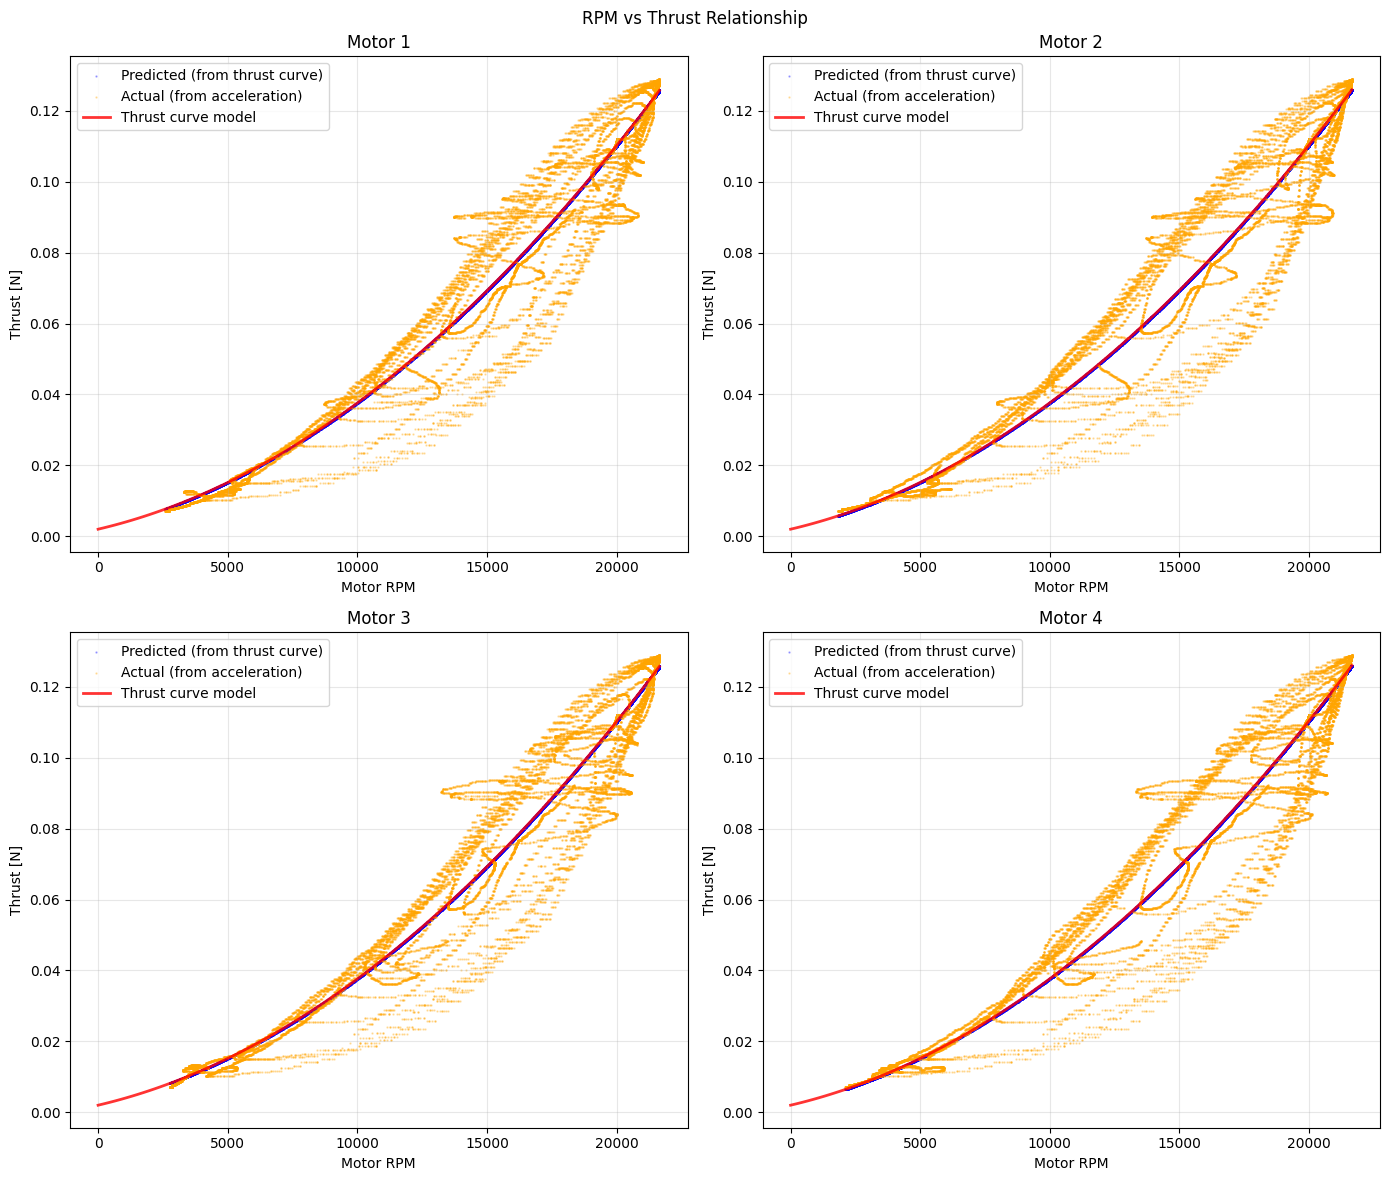

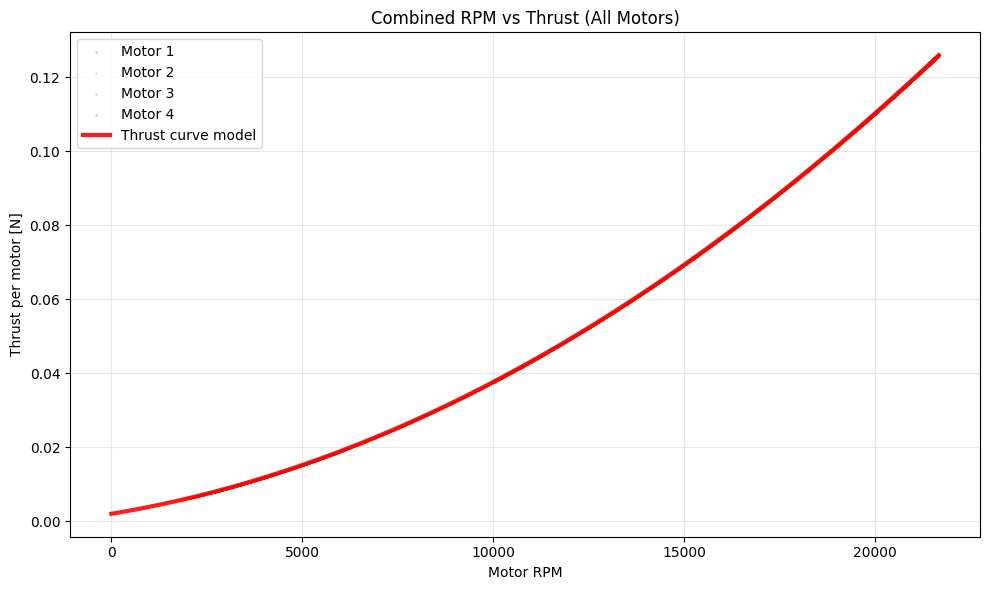


Thrust curve model:
T = 0.002012 + 0.037190*u^1 + 0.087085*u^2
where u = RPM / 21702.00 (normalized motor value)


In [131]:
# Plot RPM vs Thrust relationship (if RPM data available)
if has_rpm_data:
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Get the motor data used in estimation
    motors_data = combined_thrust["motors"]  # This is actual RPM / rpm_scale_factor (normalized to 0-1)
    thrust_per_motor = combined_thrust["thrusts"]  # Predicted thrust per motor
    
    # Also get actual thrust from acceleration
    actual_total_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]
    
    for motor_i in range(4):
        ax = axs[motor_i // 2, motor_i % 2]
        
        # Get normalized motor values (0-1 range) used in estimation
        motor_normalized = motors_data[:, motor_i]
        
        # Convert back to actual RPM for plotting
        motor_rpm = motor_normalized * rpm_scale_factor
        
        # Get predicted thrust for this motor
        predicted_motor_thrust = thrust_per_motor[:, motor_i]
        
        # Estimate "actual" thrust per motor by distributing total thrust equally
        # (This is an approximation since we can't measure individual motor thrust)
        estimated_actual_motor_thrust = actual_total_thrust / 4.0
        
        # Plot predicted thrust curve
        ax.scatter(motor_rpm, predicted_motor_thrust, 
                  s=0.5, alpha=0.3, label='Predicted (from thrust curve)', color='blue')
        
        # Plot "actual" thrust (from measured acceleration)
        ax.scatter(motor_rpm, estimated_actual_motor_thrust, 
                  s=0.5, alpha=0.3, label='Actual (from acceleration)', color='orange')
        
        # Plot the theoretical thrust curve
        rpm_range = np.linspace(0, motor_rpm.max(), 100)
        motor_range_normalized = rpm_range / rpm_scale_factor
        thrust_curve_plot = sum(K_f_mean[exp] * motor_range_normalized**exp for exp in range(len(K_f_mean)))
        ax.plot(rpm_range, thrust_curve_plot, 'r-', linewidth=2, 
               label='Thrust curve model', alpha=0.8)
        
        ax.set_xlabel('Motor RPM')
        ax.set_ylabel('Thrust [N]')
        ax.set_title(f'Motor {motor_i + 1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    fig.suptitle('RPM vs Thrust Relationship')
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_vs_thrust.png", dpi=dpi)
    plt.show()
    
    # Also create a combined plot showing all motors together
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for motor_i in range(4):
        motor_normalized = motors_data[:, motor_i]
        motor_rpm = motor_normalized * rpm_scale_factor
        predicted_motor_thrust = thrust_per_motor[:, motor_i]
        
        # Subsample for clearer visualization
        subsample_indices = np.random.choice(len(motor_rpm), min(5000, len(motor_rpm)), replace=False)
        
        ax.scatter(motor_rpm[subsample_indices], predicted_motor_thrust[subsample_indices], 
                  s=1, alpha=0.2, label=f'Motor {motor_i + 1}')
    
    # Plot the theoretical curve
    rpm_range = np.linspace(0, motors_data.max() * rpm_scale_factor, 200)
    motor_range_normalized = rpm_range / rpm_scale_factor
    thrust_curve_plot = sum(K_f_mean[exp] * motor_range_normalized**exp for exp in range(len(K_f_mean)))
    ax.plot(rpm_range, thrust_curve_plot, 'r-', linewidth=3, 
           label='Thrust curve model', alpha=0.9)
    
    ax.set_xlabel('Motor RPM')
    ax.set_ylabel('Thrust per motor [N]')
    ax.set_title('Combined RPM vs Thrust (All Motors)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_vs_thrust_combined.png", dpi=dpi)
    plt.show()
    
    # Print the thrust curve equation
    print("\nThrust curve model:")
    equation = "T = "
    for exp, coeff in enumerate(K_f_mean):
        if exp == 0:
            equation += f"{coeff:.6f}"
        else:
            sign = "+" if coeff >= 0 else "-"
            equation += f" {sign} {abs(coeff):.6f}*u^{exp}"
    print(equation)
    print("where u = RPM / {:.2f} (normalized motor value)".format(rpm_scale_factor))
    
else:
    print("No RPM data available - skipping RPM vs thrust plots")

## Step 6: Estimate Inertia (Roll and Pitch)

I_x (Roll): 7.673588e-06 kg*m^2
I_y (Pitch): 7.206059e-07 kg*m^2


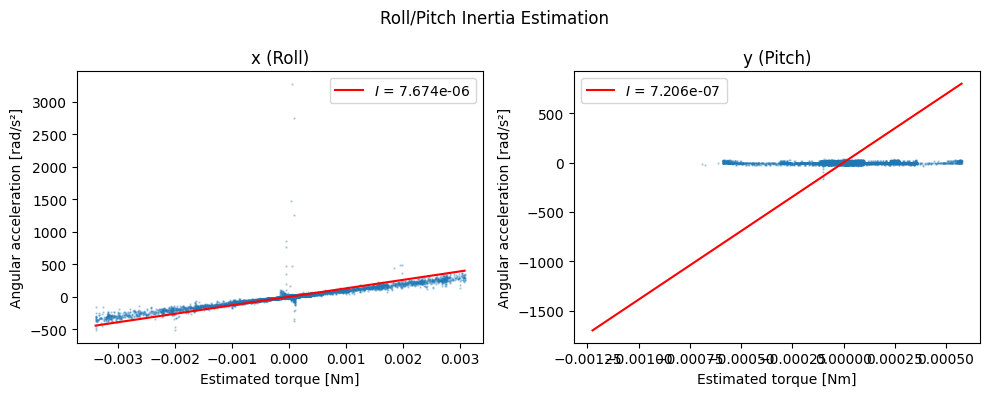

In [132]:
I = []
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for axis_i, axis_name in zip([0, 1], ["x (Roll)", "y (Pitch)"]):
    ax = axs[axis_i]
    dw_full = combined_inertia_roll_pitch["domega"][:, axis_i]
    torque_full = combined_inertia_roll_pitch["pre_torque_geometric"].sum(axis=1)[:, axis_i]
    
    # Filter to use only high-excitation data points
    perc = 50
    dw_perc_lower = np.percentile(dw_full, perc)
    dw_perc_upper = np.percentile(dw_full, 100 - perc)
    mask = (dw_full < dw_perc_lower) | (dw_full > dw_perc_upper)
    
    dw = dw_full[mask]
    torque = torque_full[mask]

    # Estimate inertia using least squares
    I_axis = 1 / (dw**2).sum() * np.inner(dw, torque)
    print(f"I_{axis_name}: {I_axis:.6e} kg*m^2")
    
    ax.scatter(torque, dw, s=0.5, alpha=0.3)
    torques_in = np.linspace(torque_full.min(), torque_full.max(), 100)
    ax.plot(torques_in, torques_in / I_axis, color="red", 
            label=f"$I$ = {I_axis:.3e}")
    ax.set_xlabel(f"Estimated torque [Nm]")
    ax.set_ylabel(f"Angular acceleration [rad/s²]")
    ax.set_title(f"{axis_name}")
    ax.legend()
    I.append(I_axis)

fig.suptitle("Roll/Pitch Inertia Estimation")
fig.tight_layout()
fig.savefig(f"figures/{model_name}_inertia_roll_pitch.png", dpi=dpi)
plt.show()

In [133]:
# Calculate yaw inertia from roll/pitch using ratio
I_xx, I_yy = I[:2]
I_zz = (I_xx + I_yy) / 2 * inertia_ratio
I = [I_xx, I_yy, I_zz]

print(f"I_xx: {I_xx:.6e} kg*m^2")
print(f"I_yy: {I_yy:.6e} kg*m^2") 
print(f"I_zz: {I_zz:.6e} kg*m^2 (estimated using ratio {inertia_ratio})")

I_xx: 7.673588e-06 kg*m^2
I_yy: 7.206059e-07 kg*m^2
I_zz: 7.554775e-06 kg*m^2 (estimated using ratio 1.8)


## Step 7: Estimate Torque Constant (K_tau)

K_tau: 6.612720e-04


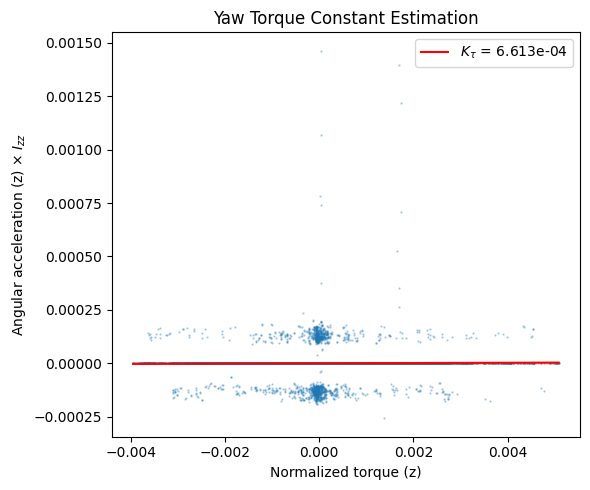

In [134]:
# Estimate yaw torque constant
thrust_torques_inputs = combined_inertia_yaw["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
thrust_torque_inputs_z = thrust_torques_inputs[:, :, 2].sum(axis=1)
dwz = combined_inertia_yaw["domega"][:, 2]

b = dwz * I_zz
K_tau = 1 / (thrust_torque_inputs_z**2).sum() * np.inner(thrust_torque_inputs_z, b)

print(f"K_tau: {K_tau:.6e}")

plt.figure(figsize=(6, 5))
plt.scatter(thrust_torque_inputs_z, b, s=0.5, alpha=0.3)
x_range = np.linspace(thrust_torque_inputs_z.min(), thrust_torque_inputs_z.max(), 100)
plt.plot(x_range, K_tau * x_range, color="red", 
         label=f"$K_\\tau$ = {K_tau:.3e}")
plt.ylabel(f"Angular acceleration (z) × $I_{{zz}}$")
plt.xlabel(f"Normalized torque (z)")
plt.legend()
plt.title("Yaw Torque Constant Estimation")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_K_tau.png", dpi=dpi)
plt.show()

## Step 8: Generate Output JSON

In [135]:
# Build final parameters dictionary
initial_keys = ['mass', 'rotor_positions', 'rotor_thrust_directions', 'rotor_torque_directions']

parameters = {
    **{key: model[key].tolist() if isinstance(model[key], np.ndarray) else model[key] for key in initial_keys},
    "thrust_coefficients": [K_f_mean.tolist()] * 4,
    "rotor_torque_constants": [float(K_tau)] * 4,
    "inertia_diag": [
        float(I_xx),
        float(I_yy),
        float(I_zz)
    ],
    "delay_rising_constants": [float(T_m)] * 4,
    "delay_falling_constants": [float(T_m)] * 4
}

print("System Identification Parameters:")
print("=" * 50)
print(json.dumps(parameters, indent=4))

System Identification Parameters:
{
    "mass": 0.036,
    "rotor_positions": [
        [
            -0.028000000000000004,
            -0.028,
            0.0
        ],
        [
            0.028000000000000004,
            -0.028,
            0.0
        ],
        [
            -0.028000000000000004,
            0.028,
            0.0
        ],
        [
            0.028000000000000004,
            0.028,
            0.0
        ]
    ],
    "rotor_thrust_directions": [
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ]
    ],
    "rotor_torque_directions": [
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            -1
        ],
        [
            0,
            0,
            -1
        ],
        [
           

In [136]:
# Save to JSON file
output_file = f"{model_name}_parameters.json"
with open(output_file, 'w') as f:
    json.dump(parameters, f, indent=4)

print(f"\nParameters saved to: {output_file}")


Parameters saved to: my_quad_parameters.json
